# Solutions of exercises for Chapter 6

In [61]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as ts

register_matplotlib_converters()


plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

import warnings
warnings.filterwarnings('ignore')


In [39]:
pd.options.display.max_columns = None
pd.options.display.width=None
sns.set(style="darkgrid")

### Exercise 1

In [53]:
df = pd.read_csv('../datasets/investment_data.csv',parse_dates=True,index_col='date')
df.tail()

,CME,GS,ICE,LM,MS
date,,,,,
2014-12-23,-0.002047,0.005437,-0.007402,0.008796,0.009804
2014-12-24,-0.001545,0.001993,-0.007638,-0.005489,-0.003601
2014-12-26,-0.002100,-0.002249,0.000676,-0.001101,-0.002322
2014-12-29,-0.002326,0.003779,0.001126,-0.000735,0.006179
2014-12-30,-0.003666,-0.002450,-0.001532,-0.012204,0.001027


In [189]:
mu = df.mean(axis=0)
sigma = df.cov()
R = mus.quantile(q = 0.5)
print(mu)
print(sigma)
print(R)

CME    0.000724
GS     0.000447
ICE   -0.000005
LM     0.000894
MS     0.000912
dtype: float64
          CME        GS       ICE        LM        MS
CME  0.000137  0.000073  0.000099  0.000096  0.000090
GS   0.000073  0.000119  0.000072  0.000104  0.000119
ICE  0.000099  0.000072  0.000179  0.000093  0.000072
LM   0.000096  0.000104  0.000093  0.000231  0.000129
MS   0.000090  0.000119  0.000072  0.000129  0.000186
0.0007242622596889368


#### Part 1

Let's write a quick function to test the acf (20 lags) and see if it is significant (at the 95%) then apply it to each instrument.
Data looks like random walks

In [108]:
def test_for_random(series):
    (acf,alpha) = ts.acf(series,nlags=20,alpha=0.05)
    return pd.Series({'IsRandom': not np.array([acf < alpha[:,0], acf > alpha[:,1]]).any()})
df.stack().groupby(level=1).apply(test_for_random)

CME  IsRandom    True
GS   IsRandom    True
ICE  IsRandom    True
LM   IsRandom    True
MS   IsRandom    True
dtype: bool

#### Part 2

We are going to leverage the excellent CVSOPT package for this exercise specifically the qp solver. See user guide [here](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)


In [130]:
from cvxopt.solvers import qp
from cvxopt import matrix

In [335]:
n = mu.shape[0]
P = matrix(sigma.values) #Covariance matrix
q = matrix(np.zeros((n,1))) # q for Markowits optimization with 0 costs i 0
A = matrix(1.0,(1,n)) #Linear equalities (only 1 in our case) states that weights must sm to 1
b = matrix(1.0)
G = -matrix(mu.values.reshape(1,n)) #Linear inequalities (1 in our case) states that the weighted combination of mus is at least R. 
h = -matrix(R,(1,1)) # Inequalities are expressed as upper bounds so need to be flipped for lower bounds.
res = qp(P,q,G,h,A,b)

     pcost       dcost       gap    pres   dres
 0:  4.8465e-05  4.8547e-05  3e-04  1e+00  2e-20
 1:  4.8465e-05  4.8547e-05  3e-06  1e-02  4e-20
 2:  4.8465e-05  4.8552e-05  3e-08  4e-04  3e-20
 3:  4.8472e-05  4.8868e-05  1e-09  3e-04  2e-20
 4:  9.6197e-05  3.3819e-05  6e-05  2e-16  2e-19
 5:  6.1161e-05  5.2832e-05  8e-06  6e-17  4e-20
 6:  5.4841e-05  5.4181e-05  7e-07  3e-17  4e-20
 7:  5.4205e-05  5.4198e-05  6e-09  6e-17  3e-20
Optimal solution found.


In [338]:
w = np.array(res['x'])
print(f'Weights:\n{np.round(w[:,0],2)}')
print(f'Expected Return: {mu.dot(w)[0]}')
print(f'Sum of W: {w.sum()}')

Weights:
[ 0.53  0.35 -0.08  0.09  0.11]
Expected Return: 0.0007244202371031096
Sum of W: 1.0


Optimization puts most weight to CME and GS and lesser on LM and MS. It shorts IC which had negative return but only a little since return was almost 0
We confirm that Expected Ret is R and weights sum to 1. 

#### Part 3

In [248]:
new_mu = np.random.uniform(0.95*mu,1.05*mu)
print(new_mu)

[ 7.56556451e-04  4.63327236e-04 -4.63292329e-06  8.62978981e-04
  8.83500139e-04]


In [249]:
G = -matrix(new_mu.reshape(1,n))
res = qp(P,q,G,h,A,b)
w = np.array(res['x'])
print(f'Weights:\n{w[:,0]}')


     pcost       dcost       gap    pres   dres
 0:  4.8464e-05  4.8534e-05  3e-04  1e+00  3e-20
 1:  4.8464e-05  4.8534e-05  3e-06  1e-02  3e-20
 2:  4.8465e-05  4.8538e-05  3e-08  4e-04  2e-20
 3:  4.8470e-05  4.8785e-05  1e-09  3e-04  3e-20
 4:  1.0639e-04  2.4678e-05  8e-05  1e-16  2e-19
 5:  6.2486e-05  5.1239e-05  1e-05  1e-16  4e-20
 6:  5.4530e-05  5.3446e-05  1e-06  1e-17  2e-20
 7:  5.3508e-05  5.3495e-05  1e-08  6e-17  3e-20
Optimal solution found.
Weights:
[ 0.53919051  0.39105176 -0.08498139  0.07841818  0.07632094]


The weights for this slightly modified set of expected return resulted in meaningfully different weights higlighting a known deficiency of Markowits mean-variance approach: Extreme sensitivity to expected returns estimates which are notoriously very noisy.

#### Part 4

In [252]:
other_mus = np.array([np.random.uniform(0.95*mu,1.05*mu) for i in range(3)])
all_mus = np.vstack((mu.values, new_mu,other_mus))

mus_mean = all_mus.mean(axis=0)
print(mus_mean)

[ 7.23138230e-04  4.50628842e-04 -4.49120079e-06  8.90903767e-04
  9.13982377e-04]


In [253]:
G = -matrix(mus_mean.reshape(1,n))
res = qp(P,q,G,h,A,b)
w = np.array(res['x'])
print(f'Weights:\n{w[:,0]}')

     pcost       dcost       gap    pres   dres
 0:  4.8465e-05  4.8546e-05  3e-04  1e+00  3e-20
 1:  4.8465e-05  4.8546e-05  3e-06  1e-02  4e-20
 2:  4.8465e-05  4.8551e-05  3e-08  4e-04  3e-20
 3:  4.8471e-05  4.8861e-05  1e-09  3e-04  2e-20
 4:  9.7769e-05  3.2693e-05  7e-05  2e-16  4e-19
 5:  6.1423e-05  5.2697e-05  9e-06  6e-17  9e-20
 6:  5.4857e-05  5.4146e-05  7e-07  3e-17  5e-20
 7:  5.4173e-05  5.4166e-05  7e-09  4e-17  3e-20
Optimal solution found.
Weights:
[ 0.52603775  0.35528604 -0.0844768   0.09213383  0.11101917]


As we average multiple random $\mu$s we see that the weigths tend to align with the original optimization

#### Part 5

Let's slightly modify the optimization to enforce posity weights. This simply requires adding n additional inequality constraints. the G addendum is the (negative) identity matrix and the h addendum is a 0 vector.

In [281]:
G_w = -np.diag(np.ones(n))
G = matrix(np.vstack((-mu.values.reshape(1,n),G_w)))
h = np.zeros(n+1)
h[0] = -R
h = matrix(h)
res = qp(P,q,G,h,A,b)
w = np.array(res['x'])
print(f'Weights:\n{np.round(w[:,0],2)}')

     pcost       dcost       gap    pres   dres
 0:  5.4910e-05 -9.9980e-01  7e+00  2e+00  3e+00
 1:  5.4916e-05 -6.9890e-01  7e-01  2e-02  3e-02
 2:  5.4925e-05 -1.7298e-02  2e-02  6e-04  6e-04
 3:  5.6295e-05 -6.7802e-03  7e-03  2e-04  2e-04
 4:  6.0673e-05 -4.1175e-04  5e-04  1e-16  8e-17
 5:  5.9915e-05  3.5806e-05  2e-05  9e-17  1e-17
 6:  5.6114e-05  5.1265e-05  5e-06  8e-17  3e-18
 7:  5.5142e-05  5.4651e-05  5e-07  8e-17  2e-19
 8:  5.4889e-05  5.4877e-05  1e-08  2e-16  4e-19
Optimal solution found.
Weights:
[0.48 0.2  0.   0.11 0.2 ]


In [282]:
G = matrix(np.vstack((-new_mu.reshape(1,n),G_w)))
res = qp(P,q,G,h,A,b)
w = np.array(res['x'])
print(f'Weights:\n{np.round(w[:,0],2)}')

     pcost       dcost       gap    pres   dres
 0:  5.4910e-05 -9.9980e-01  7e+00  2e+00  3e+00
 1:  5.4916e-05 -6.9890e-01  7e-01  2e-02  3e-02
 2:  5.4923e-05 -1.7437e-02  2e-02  6e-04  6e-04
 3:  5.6143e-05 -7.1339e-03  8e-03  2e-04  2e-04
 4:  6.0718e-05 -5.3280e-04  6e-04  8e-17  3e-16
 5:  5.9865e-05  2.8417e-05  3e-05  8e-17  2e-17
 6:  5.5810e-05  5.0223e-05  6e-06  2e-16  2e-18
 7:  5.4555e-05  5.4103e-05  5e-07  6e-17  9e-20
 8:  5.4300e-05  5.4292e-05  8e-09  4e-17  2e-19
Optimal solution found.
Weights:
[0.5  0.22 0.   0.09 0.18]


In [283]:
G = matrix(np.vstack((-mus_mean.reshape(1,n),G_w)))
res = qp(P,q,G,h,A,b)
w = np.array(res['x'])
print(f'Weights:\n{np.round(w[:,0],2)}')

     pcost       dcost       gap    pres   dres
 0:  5.4910e-05 -9.9980e-01  7e+00  2e+00  3e+00
 1:  5.4916e-05 -6.9890e-01  7e-01  2e-02  3e-02
 2:  5.4925e-05 -1.7269e-02  2e-02  6e-04  6e-04
 3:  5.6284e-05 -6.7682e-03  7e-03  2e-04  2e-04
 4:  6.0650e-05 -4.1215e-04  5e-04  8e-17  8e-17
 5:  5.9900e-05  3.5945e-05  2e-05  2e-16  8e-18
 6:  5.6102e-05  5.1286e-05  5e-06  9e-17  3e-18
 7:  5.5112e-05  5.4643e-05  5e-07  7e-17  4e-19
 8:  5.4867e-05  5.4856e-05  1e-08  1e-16  3e-19
Optimal solution found.
Weights:
[0.48 0.2  0.   0.11 0.21]


In the case of long only allocation the weights are quite extreme putting almost 50% of the portfolio in CME. This has an effect of reducing significantly the effects of diversification.

#### Part 6

We'll solve the LASSO problem still using QP. The LASSO add a non linear penalty to the objective that penalizes for the L1 norm (sum of absolute weights) with a penaly hyperparameter $\rho$. 

A common approach to add this penalty is to split the weigths $w$ in positive weights $w^{+}$ and negative weights $W^{-}$. The total weights are then: $w = w^{+} - w^{-}$ and the pe penalty term now just becomes: $\rho w^{+} + w^{-}$. To keep things working we'll also need to ensure that both $w^{+}$ and $w^{-}$ must be positive so we add that additional inequality constraint.

To ensure all is working we'll add a very small amount of penalty $\rho$ and we should retrieve a similar set of weights of the original problem.

In [340]:
rho = 10e-9

P = matrix(np.vstack((np.hstack((sigma,-sigma)),np.hstack((-sigma,sigma))))) # adjusted P to work with w+ and w-
q = matrix(rho,(2*n,1)) #L1 norm

A = matrix(np.hstack((np.ones((1,n)),-np.ones((1,n))))) #A - A to enforse that the sum of weights w+ - w- sum up to1
b = matrix(1.0)

G_1 =  np.hstack((-mu.values.reshape(1,n), mu.values.reshape(1,n))) #This ensures linear combination of mu*(w+-w-) is at least R

G_w = -np.diag(np.ones(2*n)) # This component ensure that w+ >0 and w- >0. Again we flip it to make it a <= constraint
G = matrix(np.vstack((G_1,G_w)))

h = np.zeros(2*n +1)
h[0] = -R
h = matrix(h)

res = qp(P,q,G,h,A,b)

     pcost       dcost       gap    pres   dres
 0:  5.4909e-05  1.0020e-01  1e+01  4e+00  3e+00
 1:  5.5075e-05 -1.2491e-01  1e-01  4e-02  4e-02
 2:  6.4355e-05 -7.2921e-03  8e-03  2e-03  2e-03
 3:  1.0538e-04 -3.8084e-04  5e-04  1e-04  1e-04
 4:  6.4780e-05  3.3831e-05  3e-05  5e-06  5e-06
 5:  5.5504e-05  5.3941e-05  2e-06  6e-08  5e-08
 6:  5.4265e-05  5.4202e-05  6e-08  4e-16  3e-19
Optimal solution found.


In [341]:
w = np.array(res['x']).reshape(2,n)
print(f'W+:{np.round(w[0],2)}\nW-:{np.round(w[1],2)}')
w_total = w[0]-w[1]
print(f'W:{np.round(w_total,2)}')

print(f'Expected Return: {mu.dot(w_total)}')
print(f'Sum of W: {w_total.sum()}')

W+:[0.83 0.73 0.51 0.51 0.53]
W-:[0.3  0.38 0.6  0.42 0.42]
W:[ 0.53  0.35 -0.08  0.09  0.11]
Expected Return: 0.0007246303526336134
Sum of W: 1.0000000000000004


As we can see the weights are the same  as the original problem. Let's try with a  more binding $\rho$

In [357]:
rho = 10e-4
q = matrix(rho,(2*n,1))
res = qp(P,q,G,h,A,b)

     pcost       dcost       gap    pres   dres
 0:  4.4909e-05  1.1119e-01  1e+01  4e+00  3e+00
 1:  1.0924e-02 -1.1943e-01  1e-01  4e-02  4e-02
 2:  9.3709e-03 -5.6091e-05  9e-03  2e-04  2e-04
 3:  1.2210e-03  5.3046e-04  7e-04  1e-05  1e-05
 4:  1.2168e-03  1.0013e-03  2e-04  1e-06  1e-06
 5:  1.1641e-03  1.0191e-03  1e-04  8e-07  7e-07
 6:  1.0674e-03  1.0512e-03  2e-05  7e-08  7e-08
 7:  1.0561e-03  1.0541e-03  2e-06  5e-09  5e-09
 8:  1.0549e-03  1.0549e-03  4e-08  8e-11  7e-11
Optimal solution found.


In [358]:
w = np.array(res['x']).reshape(2,n)
print(f'W+:{np.round(w[0],2)}\nW-:{np.round(w[1],2)}')
w_total = w[0]-w[1]
print(f'W:{np.round(w_total,2)}')

print(f'Expected Return: {mu.dot(w_total)}')
print(f'Sum of W: {w_total.sum()}')

W+:[0.48 0.2  0.   0.11 0.2 ]
W-:[0. 0. 0. 0. 0.]
W:[0.48 0.2  0.   0.11 0.2 ]
Expected Return: 0.0007242672830153126
Sum of W: 1.0


After trying a few values for $\rho$  we find that for values > 10e-5 the weights are actually similar to the weigth calculated in part 5. 

### Exercise 2

Suppose that it is impractical to construct an efficient portfolio using all assets. One alternative is to find a portfolio, made up of a given set of $n$ stocks, that tracks the efficient portfolio closely—in the sense of minimizing the variance of the difference in returns.

Specifically, suppose that the efficient portfolio has (random) rate of return $r_{M}$. Suppose that there are $N$ assets with (random) rates of return $r_{1},r_{2},…,r_{n}$. We wish to find the portfolio whose rate of return is $r = \alpha_{1}r_{1} + \alpha_{2}r_{2} + ...+ \alpha_{n}r_{n} (  with \sum_{i=1}^{n} \alpha_{i} = 1)$ by minimizing $Var(r-r_{M})$.

1. Find a set of equations for the $\alpha_{i}$s.
2. Another approach is to minimize the variance of the tracking error subject to achieving a given mean return. Find the equation for the $\alpha_{i}$s that are tracking efficient.
3. Instead of minimizing $Var(r-r_{M})$, obtain the $\alpha_{i}$s that result from minimizing meansquares
of the difference of $(r-r_{M})$. Note the mean squares is the sum of variance and bias squared.

#### Part 1

Let's define $\alpha$ as the vector of weigths, and $\eta = Cov(r_{i},r_{M})$

$$Var(r-r_{M}) = \mathbb{E}{(\sum_{j=1}^{n}\alpha_{j}(r_{j} - \mathbb{E}{r_{j}}) - (r_{M} - \mathbb{E}{r_{M}}))^{2}}$$
$$=\mathbb{E}{(\sum_{j=1}^{n}\alpha_{j}(r_{j} - \mathbb{E}{r_{j}}))^{2}} - 2 \mathbb{E}{(\sum_{j=1}^{n}\alpha_{j}(r_{j} - \mathbb{E}{r_{j}})(r_{M} - \mathbb{E}{r_{M}})} + \mathbb{E}{(r_{M} - \mathbb{E}{r_{M}})^{2}}$$
$$=\alpha^{T}\Sigma\alpha - 2\alpha^{T}\eta + Var(r_{M})$$

We want to minimize $Var(r-r_{M})$ subject to $\sum_{j=1}^{n}\alpha_{j}=1$

We build the Lagrangian function:
$$L(\alpha,\lambda) = \alpha^{T}\Sigma\alpha - 2\alpha^{T}\eta + Var(r_{M})-2\lambda(\alpha^{T}e -1)$$

con $e = (1,...,1)^{T}$
We calculate the gradient $\nabla{L(\alpha,\lambda)}$ and set it to 0

$$\nabla{L(\alpha,\lambda)}= 2\Sigma\alpha - 2\eta-2\lambda e = 0$$
$$\Longrightarrow \alpha = \Sigma^{-1}(\eta+\lambda e)$$

Forcing the constraint that $ 1=e^{T}\alpha= e^{T}\Sigma^{-1}\eta +  e^{T}\Sigma^{-1}\lambda e)$ we get:
$$ \lambda = \frac{1-e^{T}\Sigma^{-1}\eta }{e^{T}\Sigma^{-1}\lambda e}$$

Therefore $\alpha$ satisfies:
$$\alpha = \Sigma^{-1}(\eta + \frac{1-e^{T}\Sigma^{-1}\eta }{e^{T}\Sigma^{-1}\lambda e})$$

#### Part 2 

Assuming expected mean return $R$ and $\bar{r} = (\mathbb{E}{r_{1}},...,\mathbb{E}{r_{n}})^{T}$. The optimization problem becomes:

$$ \underset{\alpha}{\text{minimize }} \frac{1}{2}\alpha^{T}\Sigma\alpha - \alpha^{T}\eta$$
$$ \text{subject to } \alpha^{T}e =1, \alpha^{T}\bar{r}\geq R$$

The Lagrangian function is:

$$L(\alpha,\beta,\rho) = \frac{1}{2}\alpha^{T}\Sigma\alpha - \alpha^{T}\eta +\beta(1- \alpha^{T}e) + \rho(R-\alpha^{T}\bar{r})$$

Then $\alpha$ should satisfy the KKT conditions, which are

$$ \nabla{L(\alpha,\beta,\rho)}  =  \Sigma\alpha -\eta -\beta e -\rho \bar{r} = 0$$
$$  \alpha^{T}e =1, \alpha^{T}\bar{r}\geq R, \rho \geq 0 , \rho(R-\alpha^{T}\bar{r})=0$$

### Exercise 3

The file m_logret_10stocks.csv contains the monthly returns of ten stocks from January 1994 to December 2006. The ten stocks include Apple, Adobe Systems, Automatic Data Processing, Advanced Micro Devices, Dell, Gateway, Hewlett-Packard Company, International Business Machines Corp., and Oracle Corp. 

Consider portfolios that consist of these ten stocks.
1. Compute the sample mean $\hat{ \mu }$ and the sample covariance matrix $\hat{\Sigma}$ of the log returns.
2. Assume that the monthly target return is 0.3% and that short selling is allowed. Estimate the optimal portfolio weights by replacing $(\mu, \Sigma)$ in Markowitz’s Theory by $(\hat{\mu},\hat{\Sigma})$.
3. Do the same as in (2) for Michaud’s resampled weights described in the text using D = 500 bootstrap samples.
4. Plot the estimated frontier (by varying $\mu^{*}$ over a grid that uses $(\hat{\mu},\hat{\Sigma})$ to replace $(\mu, \Sigma)$ in Markowitz’s efficient frontier.
5. Plot Michaud’s resampled efficient frontier using D = 500 bootstrap samples. Compare the plot in (5).

In [360]:
df = pd.read_csv('../datasets/d_logret_16stocks.csv',index_col='date',parse_dates=True)
df.head()

,AIG,AXP,BA,DD,DIS,GM,HD,HWP,IBM,JPM,MCD,MRK,MSFT,T,VZ,WMT
date,,,,,,,,,,,,,,,,
2000-01-12,0.029679,-0.005222,0.004364,0.004535,-0.073313,0.046053,-0.008155,0.034515,0.006289,0.017392,0.041797,0.019500,-0.033114,0.063776,NaN,-0.018087
2000-01-13,0.027151,0.005222,-0.016094,-0.008178,0.032850,0.000000,0.017251,0.003331,-0.011561,0.026297,-0.010287,0.004189,0.018725,-0.023149,NaN,0.000960
2000-01-14,0.018248,0.022188,0.037631,-0.016328,-0.036567,0.074108,-0.003023,-0.002220,0.011561,0.041371,0.006992,-0.008396,0.040335,0.024293,NaN,-0.009643
2000-01-18,-0.051149,-0.051046,0.022473,-0.028456,0.027550,0.009077,-0.023482,0.009400,-0.030772,-0.037308,-0.026381,-0.045717,0.026917,-0.024293,NaN,0.016339
2000-01-19,-0.019803,-0.017471,0.056695,-0.013449,0.007220,-0.018238,0.022473,0.021237,0.038060,-0.017899,0.020865,0.009662,-0.074817,-0.004695,NaN,-0.023145


### Exercise 4

The file portfolio_data.csv contains historical monthly returns for one set of 6 portfolios and another set of 25 portfolios, formed based on Size and Book-to-Market ratio (BM). The data is obtained from French’s data library. The portfolios are formed as the intersection of size (or market equity, ME) based portfolios and book equity to market equity ratio (BE/ME) based portfolios (2×3 forming the first set of 6 portfolios and 5 × 5 forming the second set of 25 portfolios). These portfolios are discussed in the 1993 paper by Fama and French.

In this exercise we will only work with the first set of 6 portfolios, which are contained in the columns named beginning with “PF6,” with the rest of the column names following French’s naming convention about the size and BM of the corresponding portfolios – SML contains small size + low BM, SM2 contains small size + medium BM, SMH contains small size + high BM, BIGL contains big size + low BM, etc. Finally, the last 4 columns of the data set contain the Fama-French factors themselves along with the risk-free rate: MktMinusRF contains the excess return of the market over the risk-free rate, SMB contains the small-minus-big size factor, HML
contains the high-minus-low BM factor and RF contains the risk-free rate.

1. Using the entire sample, regress the excess returns (over the risk-free rate) of each of the 6 portfolios on the excess market return, and perform tests with a size of 5% that the intercept is 0. Report the point estimates, $t$-statistics, and whether or not you reject the CAPM. Performregression diagnostics to check your specification.

2. For each of the 6 portfolios, perform the same test over each of the two equipartitioned subsamples and report the point estimates, $t$-statistics, and whether or not you reject the CAPM in each subperiod. Also include the same diagnostics as above.

3. Repeat (1) and (2) by regressing the excess portfolio returns on all three Fama-French factors (excess market return, SMB factor and HML factor).

4. Jointly test that the intercepts for all 6 portfolios are zeros using the $F$-test statistic or Hotelling’s $T^2$ for the whole sample and for each subsample when regressing on all three Fama-French factors.

5. Are the 6 portfolios excess returns (over the risk-free rate) series co-integrated? Use Johansen’s test to identify the number of co-integrating relationships.

#### Part 1


In [5]:
portfolios = pd.read_csv('../datasets/portfolio_data.csv',index_col='MONTH')
portfolios.index = pd.to_datetime(portfolios.index,format='%Y%m')
portfolios.head()

,PF6_SML,PF6_SM2,PF6_SMH,PF6_BIGL,PF6_BIG2,PF6_BIGH,PF25_SML,PF25_SM2,PF25_SM3,PF25_SM4,PF25_SMH,PF25_TWOL,PF25_TWO2,PF25_TWO3,PF25_TWO4,PF25_TWOH,PF25_THREEL,PF25_THREE2,PF25_THREE3,PF25_THREE4,PF25_THREEH,PF25_FOURL,PF25_FOUR2,PF25_FOUR3,PF25_FOUR4,PF25_FOURH,PF25_BIGL,PF25_BIG2,PF25_BIG3,PF25_BIG4,PF25_BIGH,MktMinusRF,SMB,HML,RF
MONTH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1926-07-01,1.53,0.90,0.09,5.74,1.92,1.35,3.61,-3.69,-0.64,-1.42,-0.64,3.42,3.26,2.42,-1.27,2.46,1.56,2.86,-1.34,3.34,-2.16,3.29,1.24,1.29,0.55,2.56,3.18,6.08,2.00,2.93,0.56,2.62,-2.16,-2.92,0.22
1926-08-01,-0.68,2.25,5.56,2.70,2.70,6.21,-1.94,-6.78,3.81,1.21,4.82,1.59,-2.91,3.02,2.14,7.47,-1.06,1.67,2.08,4.86,8.14,0.76,4.11,1.93,2.13,4.47,1.17,4.10,1.82,5.64,7.76,2.56,-1.49,4.88,0.25
1926-09-01,-2.48,-0.06,-0.57,1.46,0.05,-0.46,-6.41,3.45,-5.19,3.08,0.75,-2.81,-2.32,1.15,-1.54,-2.61,-0.46,1.25,-2.37,1.01,-2.74,1.87,-0.08,-1.84,1.56,2.18,-1.37,3.66,-0.23,-0.30,-2.43,0.36,-1.38,-0.01,0.23
1926-10-01,-3.58,-4.60,-1.70,-3.60,-2.36,-4.05,-8.66,-10.02,-3.80,0.04,-3.06,-3.65,-3.77,-7.02,-6.29,0.08,-4.80,-2.23,-0.05,-1.73,-3.73,0.13,-1.71,-2.33,-2.93,-5.21,-3.14,-3.13,-2.21,-4.59,-5.81,-3.43,0.04,0.71,0.32
1926-11-01,2.72,3.74,2.16,3.30,2.81,3.24,3.77,12.42,2.31,-3.36,1.40,1.50,-2.77,4.03,3.46,1.62,1.78,4.64,3.27,3.54,3.40,3.54,2.28,3.85,5.00,1.78,4.31,2.61,1.47,3.55,2.56,2.44,-0.24,-0.31,0.31


In [6]:
#Select only the P6 Columns
p6_cols = [col for col in portfolios.columns if col.startswith('PF6')]
p6_returns = portfolios.loc[:,p6_cols]
p6_returns.head()

,PF6_SML,PF6_SM2,PF6_SMH,PF6_BIGL,PF6_BIG2,PF6_BIGH
MONTH,,,,,,
1926-07-01,1.53,0.90,0.09,5.74,1.92,1.35
1926-08-01,-0.68,2.25,5.56,2.70,2.70,6.21
1926-09-01,-2.48,-0.06,-0.57,1.46,0.05,-0.46
1926-10-01,-3.58,-4.60,-1.70,-3.60,-2.36,-4.05
1926-11-01,2.72,3.74,2.16,3.30,2.81,3.24


In [7]:
factor_returns = portfolios.loc[:,['MktMinusRF','SMB','HML','RF']]
factor_returns.head()

,MktMinusRF,SMB,HML,RF
MONTH,,,,
1926-07-01,2.62,-2.16,-2.92,0.22
1926-08-01,2.56,-1.49,4.88,0.25
1926-09-01,0.36,-1.38,-0.01,0.23
1926-10-01,-3.43,0.04,0.71,0.32
1926-11-01,2.44,-0.24,-0.31,0.31


In [8]:
excess_ret = p6_returns.sub(factor_returns.RF,axis=0)

We uses the statsmodel OLS that is very easy to use. We collect the most important stats but we also save the models to run the diagnostics later on

In [9]:
results = []
models = {}
colnames = ['Ind. Variable','Estimate','Std. Error','t value','p value']
X = factor_returns.MktMinusRF
X = sm.add_constant(X)

for port in p6_cols:
    y = excess_ret.loc[:,port]
    res = sm.OLS(y,X).fit()
    models[port] = res
    
    df = pd.DataFrame([res.params,res.bse,res.tvalues,res.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    results.append(df.set_index(['Portfolio','Ind. Variable']))
     
results = pd.concat(results)

results

Estimate  Std. Error     t value        p value
Portfolio Ind. Variable                                                 
PF6_SML   const         -0.103909    0.110644   -0.939128   3.478841e-01
          MktMinusRF     1.275123    0.020212   63.086567   0.000000e+00
PF6_SM2   const          0.239926    0.093145    2.575832   1.013781e-02
          MktMinusRF     1.185292    0.017016   69.659514   0.000000e+00
PF6_SMH   const          0.351316    0.128336    2.737478   6.297458e-03
          MktMinusRF     1.329283    0.023444   56.700126  1.389708e-319
PF6_BIGL  const         -0.001274    0.036720   -0.034703   9.723235e-01
          MktMinusRF     0.964168    0.006708  143.733804   0.000000e+00
PF6_BIG2  const          0.032753    0.053862    0.608091   5.432605e-01
          MktMinusRF     1.019304    0.009839  103.594556   0.000000e+00
PF6_BIGH  const          0.130636    0.097478    1.340162   1.804871e-01
          MktMinusRF     1.203306    0.017807   67.574722   0.000000e+00

Of all the portfolios examined we see that only SM2 and SMH have statistically significant p-values indicating that the excess returns is different from 0. So for these 2 portfolios we reject the CAPM model implying that these 2 portfolios have **alpha**. All other portfolios do not seem to have any alpha.

Before we confirm the results it's good practice to run some diagnostics on the residuals of the model fit. Python does not have very good plots for these while R has good ones out of the box. The below function replicates the R based plots. The code was adapted from [this excellent post](https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034).
For more information about the Regression diagnostics refer to the reference section of the [R documentation](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/plot.lm)

We'll run it as an example for on portfolio: SM2. the studend can run this for the other portfolios.

In [10]:

def create_diagnostic_plots(res,y,title=''):
    
    #fitted values
    model_fitted_y = res.fittedvalues
    # model residuals
    model_residuals = res.resid
    # normalized residuals
    model_norm_residuals = res.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = res.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = res.get_influence().cooks_distance[0]
    
    fig,ax = plt.subplots(2,2, figsize=(16,10))
    _ = fig.suptitle(title,y = 1, fontsize=16)
    
    #Residual vs. Fitted
    sns.residplot(model_fitted_y,y, lowess=True, scatter_kws={'alpha': 0.5},line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},ax =ax[0,0])
    _ = ax[0,0].set_title('Residuals vs Fitted')
    _ = ax[0,0].set_xlabel('Fitted values')
    _ = ax[0,0].set_ylabel('Residuals')
    #_ = ax[0,0].axes.set_xlim(-5,5)

    #Normal QQ Plot
    pplot = sm.ProbPlot(model_norm_residuals)
    _ = pplot.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1,ax=ax[0,1])
    _ =  ax[0,1].set_title('Normal Q-Q')
    _ =  ax[0,1].set_xlabel('Theoretical Quantiles')
    _ =  ax[0,1].set_ylabel('Standardized Residuals')
    #_ =  ax[0,1].axes.set_xlim(-3,3)

    #Scale Location Plot
    _ = ax[1,0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    _ = sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                ax=ax[1,0]
               );
    _ = ax[1,0].set_title('Scale-Location')
    _ = ax[1,0].set_xlabel('Fitted values')
    _ = ax[1,0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
    
    
    #Leverage Plot
    _ = ax[1,1].scatter(model_leverage, model_norm_residuals, alpha=0.5);
    _ = sns.regplot(model_leverage, model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                ax=ax[1,1]
               );
    _ = ax[1,1].set_xlim(0, max(model_leverage)+0.01)
    _ = ax[1,1].set_ylim(-3, 5)
    _ = ax[1,1].set_title('Residuals vs Leverage')
    _ = ax[1,1].set_xlabel('Leverage')
    _ = ax[1,1].set_ylabel('Standardized Residuals');   

    
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        ax[1,1].plot(x, y, label=label, lw=1, ls='--', color='red')

    p = len(res.params) # number of model parameters

    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50), 
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50)) # 1 line
    ax[1,1].legend(loc='bottom right');
    
    
    sns.despine()
    plt.tight_layout()
    plt.show()

#### Diagnosticts for SM2



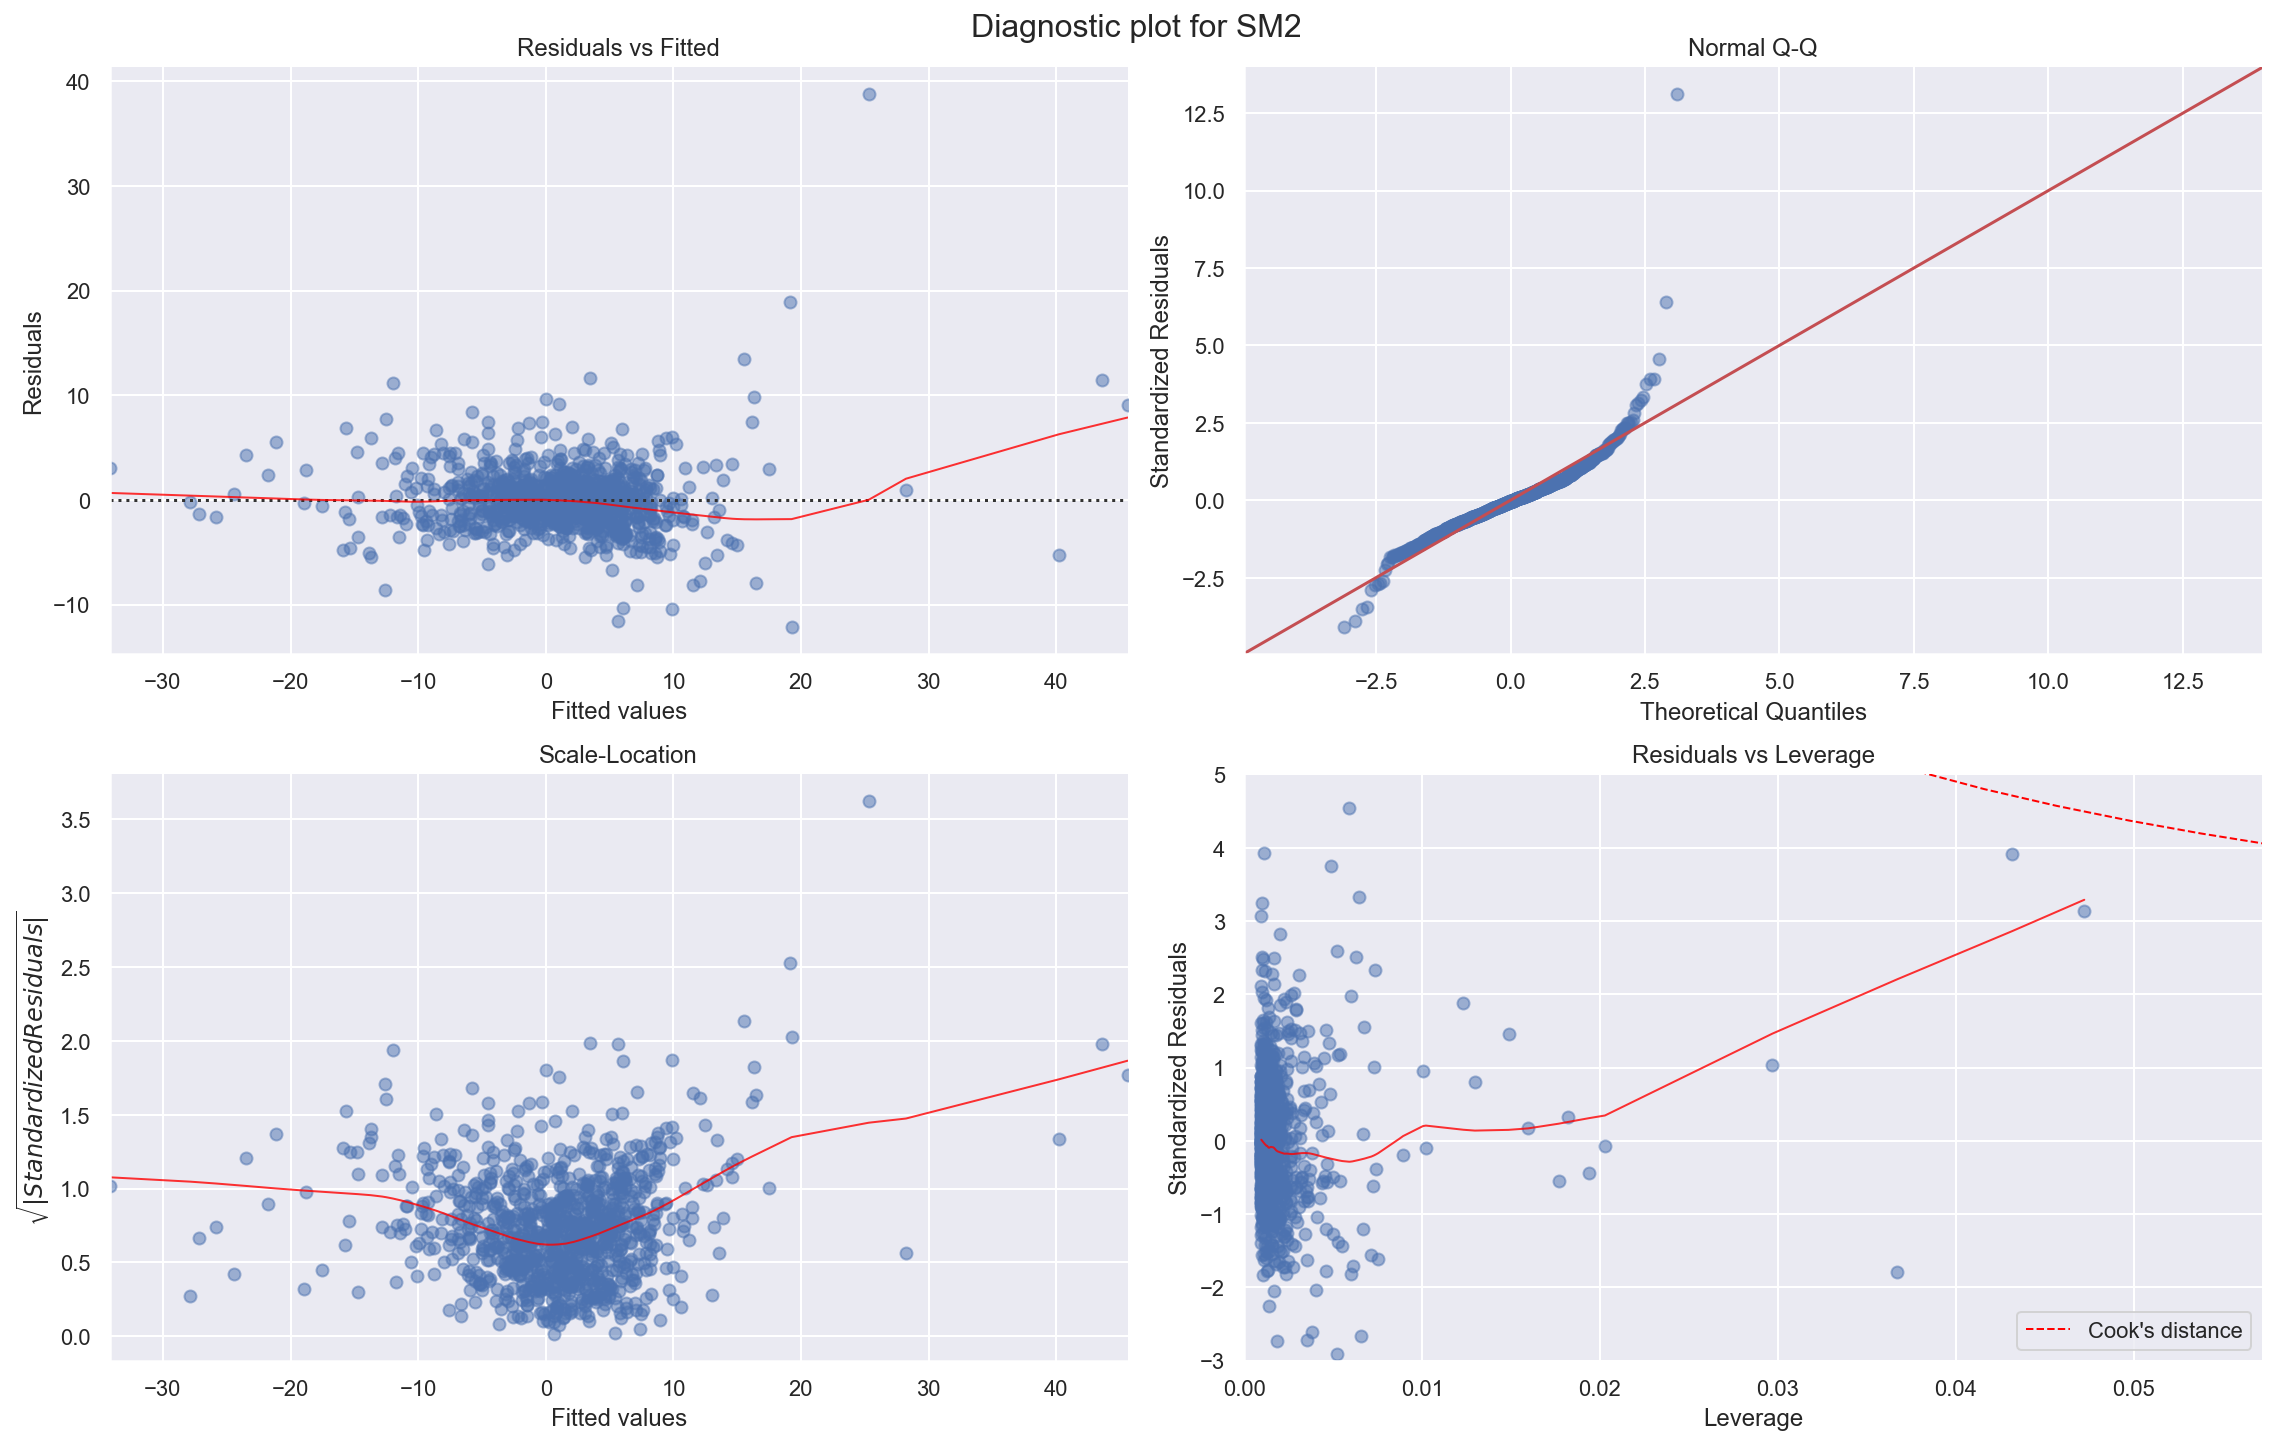

In [11]:
create_diagnostic_plots(models['PF6_SM2'],excess_ret.PF6_SM2,f'Diagnostic plot for SM2')

1. The residual vs. Fitted plot shows that the linearity assumption in the model break down due some extreme values
2. QQ Plot show that residual deviate significantly from normal and as expceted there are some heavy tails
3. Scale-Location plot shows that there is heteroscedasticity in the data i.e variance is not constant
4. Leverage plot show that none of the points are outside the Cook's distance so there is no undue influence by high leverage points

#### Part 2

We run the same analysis for 2 sub periods of the whole timeframe. Very similar analysis

In [12]:
mid_point_date = factor_returns.index[int(factor_returns.index.shape[0]/2)].date().strftime('%Y-%m-%d')
print(f'Sub-period divide date {mid_point_date}')
results_sub = []
models_sub = {}
colnames = ['Ind. Variable','Estimate','Std. Error','t value','p value']

X1 = factor_returns.loc[:mid_point_date, 'MktMinusRF']
X1 = sm.add_constant(X1)

X2 = factor_returns.loc[mid_point_date:, 'MktMinusRF']
X2 = sm.add_constant(X2)

for port in p6_cols:
    y1 = excess_ret.loc[:mid_point_date,port]
    y2 = excess_ret.loc[mid_point_date:,port]

    res1 = sm.OLS(y1,X1).fit()
    res2 = sm.OLS(y2,X2).fit()

    models_sub[f'{port}_1'] = res1
    models_sub[f'{port}_2'] = res2

    df = pd.DataFrame([res1.params,res1.bse,res1.tvalues,res1.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    df['SubPeriod'] = 1
    results_sub.append(df.set_index(['Portfolio','SubPeriod','Ind. Variable']))

    df = pd.DataFrame([res2.params,res2.bse,res2.tvalues,res2.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    df['SubPeriod'] = 2
    results_sub.append(df.set_index(['Portfolio','SubPeriod','Ind. Variable']))
     
results_sub = pd.concat(results_sub)

results_sub

Sub-period divide date 1969-09-01


Estimate  Std. Error     t value  \
Portfolio SubPeriod Ind. Variable                                     
PF6_SML   1         const          0.039161    0.161724    0.242149   
                    MktMinusRF     1.239757    0.026290   47.157878   
          2         const         -0.240227    0.150190   -1.599489   
                    MktMinusRF     1.332966    0.031997   41.658803   
PF6_SM2   1         const          0.164178    0.141471    1.160503   
                    MktMinusRF     1.264406    0.022997   54.980765   
          2         const          0.315244    0.116013    2.717319   
                    MktMinusRF     1.050185    0.024716   42.490121   
PF6_SMH   1         const          0.231339    0.204597    1.130708   
                    MktMinusRF     1.501280    0.033259   45.139327   
          2         const          0.468540    0.134871    3.473980   
                    MktMinusRF     1.035154    0.028734   36.025809   
PF6_BIGL  1         const          0.024428    0.047147    0.518124   
                    MktMinusRF     0.939130    0.007664  122.537048   
          2         const         -0.023212    0.055282   -0.419890   
                    MktMinusRF     1.006384    0.011778   85.449594   
PF6_BIG2  1         const         -0.053408    0.073665   -0.725007   
                    MktMinusRF     1.085895    0.011975   90.680998   
          2         const          0.114913    0.072867    1.577031   
                    MktMinusRF     0.906435    0.015524   58.389436   
PF6_BIGH  1         const          0.035773    0.144435    0.247677   
                    MktMinusRF     1.382308    0.023479   58.874238   
          2         const          0.218250    0.104025    2.098044   
                    MktMinusRF     0.897383    0.022162   40.491741   

                                         p value  
Portfolio SubPeriod Ind. Variable                 
PF6_SML   1         const           8.087606e-01  
                    MktMinusRF     2.155308e-189  
          2         const           1.103240e-01  
                    MktMinusRF     3.386372e-167  
PF6_SM2   1         const           2.463796e-01  
                    MktMinusRF     4.006345e-218  
          2         const           6.802468e-03  
                    MktMinusRF     1.257128e-170  
PF6_SMH   1         const           2.587024e-01  
                    MktMinusRF     1.737873e-181  
          2         const           5.559304e-04  
                    MktMinusRF     5.776675e-143  
PF6_BIGL  1         const           6.045934e-01  
                    MktMinusRF      0.000000e+00  
          2         const           6.747403e-01  
                    MktMinusRF     1.024173e-306  
PF6_BIG2  1         const           4.687756e-01  
                    MktMinusRF     1.300776e-319  
          2         const           1.154012e-01  
                    MktMinusRF     1.657901e-229  
PF6_BIGH  1         const           8.044828e-01  
                    MktMinusRF     2.254412e-231  
          2         const           3.638691e-02  
                    MktMinusRF     2.561963e-162

By looking at the sub periods we can now see that for all the first sub period  (prior to September 1969) to we cannot reject CAPM for any of the portfolios implying that before this time the Fama French factors were not really significant.

For the 2nd period we no reject CAPM for 3 portfolios: SM2, SMH, BIGH. We look at the diagnostics for BIGH Period 2. We leave to the student running the diagnostics on some of the other portofilos. 

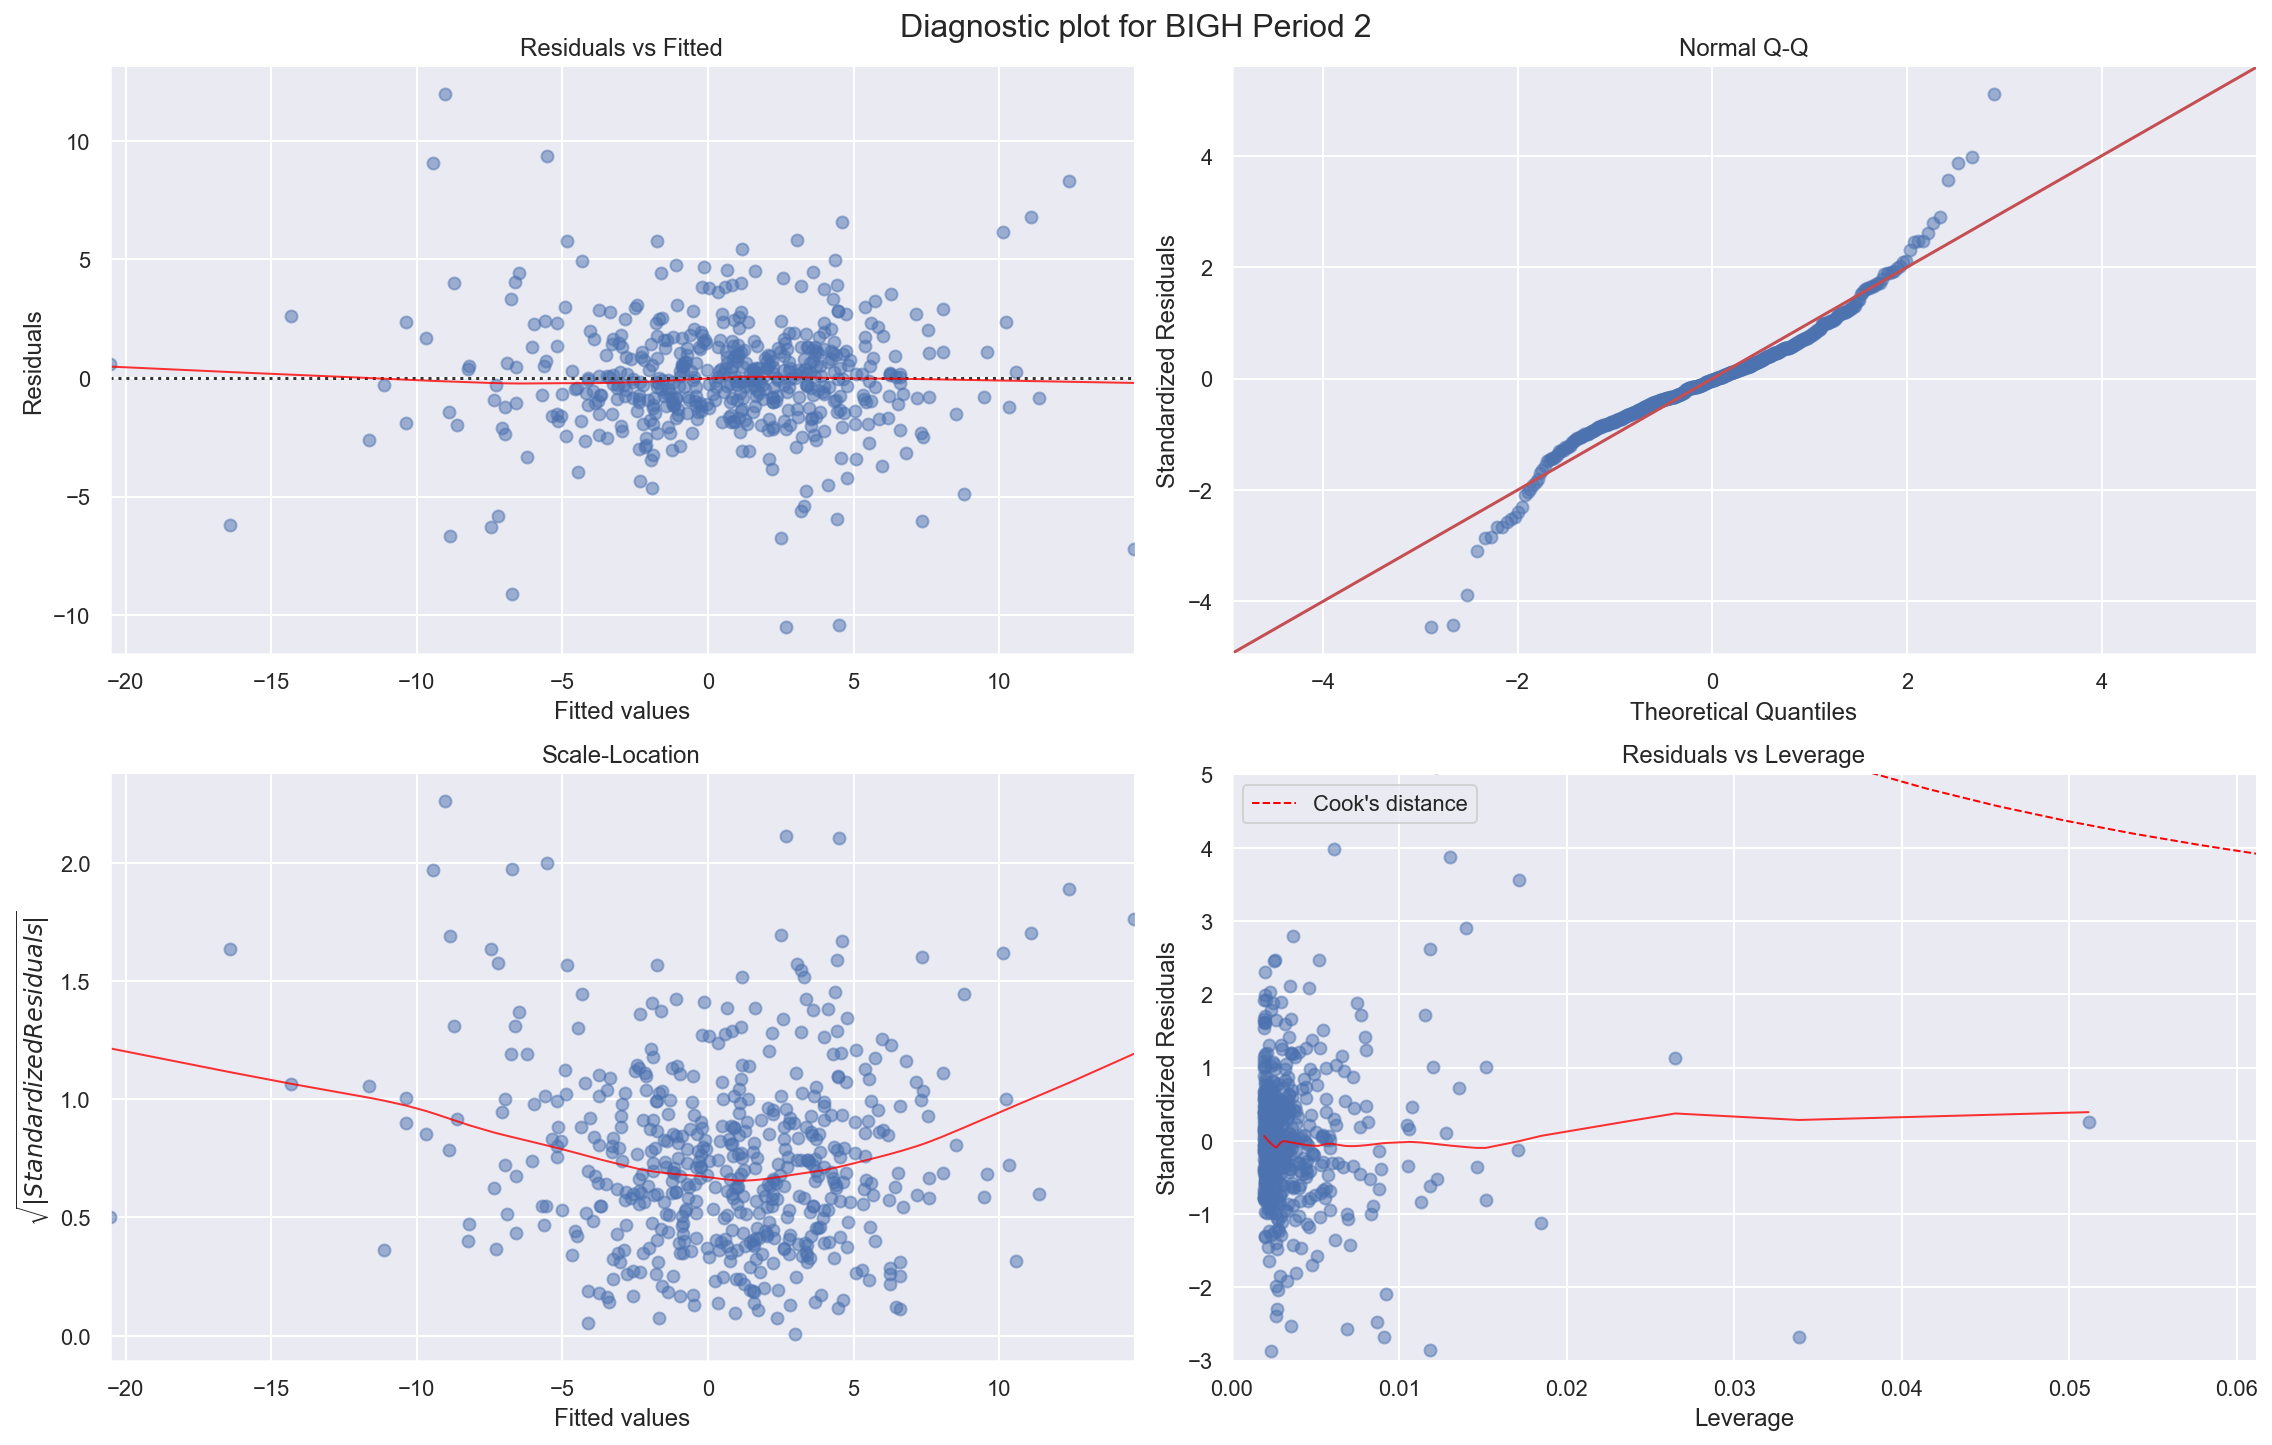

In [13]:
create_diagnostic_plots(models_sub['PF6_BIGH_2'],excess_ret.loc[mid_point_date:,'PF6_BIGH'],f'Diagnostic plot for BIGH Period 2')

1. The residual vs. Fitted plot shows that the linearity assumption holds pretty well
2. QQ Plot show that residual deviate significantly from normal and as expceted there are some heavy tails
3. Scale-Location plot shows that there is heteroscedasticity in the data i.e variance is not constant
4. Leverage plot show that none of the points are outside the Cook's distance so there is no undue influence by high leverage points

#### Part 3

This analysis expands the CAP analysis to consider the Fama-French factor model that incorporates 2 additional explanatory factors: the Size factor, SMB (Small-vs-Big) and the Momentum factor HML (High-vs-Low).


In [14]:
results = []
models = {}
colnames = ['Ind. Variable','Estimate','Std. Error','t value','p value']
X = factor_returns.loc[:,['MktMinusRF','SMB','HML']]
X = sm.add_constant(X)

for port in p6_cols:
    y = excess_ret.loc[:,port]
    res = sm.OLS(y,X).fit()
    models[port] = res
    
    df = pd.DataFrame([res.params,res.bse,res.tvalues,res.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    results.append(df.set_index(['Portfolio','Ind. Variable']))
     
results = pd.concat(results)

results

Estimate  Std. Error     t value        p value
Portfolio Ind. Variable                                                 
PF6_SML   const         -0.168496    0.039251   -4.292720   1.931147e-05
          MktMinusRF     1.088606    0.007732  140.800094   0.000000e+00
          SMB            1.050228    0.012472   84.204572   0.000000e+00
          HML           -0.167439    0.011236  -14.902513   1.233089e-45
PF6_SM2   const          0.062526    0.033371    1.873652   6.126083e-02
          MktMinusRF     0.976533    0.006573  148.560289   0.000000e+00
          SMB            0.818323    0.010604   77.172057   0.000000e+00
          HML            0.302070    0.009552   31.622296  5.271956e-154
PF6_SMH   const          0.020199    0.024671    0.818751   4.131176e-01
          MktMinusRF     1.026935    0.004859  211.325589   0.000000e+00
          SMB            0.933118    0.007839  119.032498   0.000000e+00
          HML            0.782961    0.007062  110.871403   0.000000e+00
PF6_BIGL  const          0.076967    0.025101    3.066291   2.223729e-03
          MktMinusRF     1.017402    0.004944  205.773981   0.000000e+00
          SMB           -0.096530    0.007976  -12.102663   1.265834e-31
          HML           -0.230720    0.007185  -32.111008  2.039936e-157
PF6_BIG2  const         -0.050721    0.039072   -1.298118   1.945369e-01
          MktMinusRF     0.995610    0.007696  129.362377   0.000000e+00
          SMB           -0.122330    0.012415   -9.853062   5.965396e-22
          HML            0.329236    0.011184   29.437151  9.083441e-139
PF6_BIGH  const         -0.112149    0.040618   -2.761026   5.864194e-03
          MktMinusRF     1.079117    0.008001  134.875488   0.000000e+00
          SMB            0.020473    0.012907    1.586206   1.129988e-01
          HML            0.818839    0.011627   70.426032   0.000000e+00

Once we take the othe factor into account we notices 2 importand things:
1. The previous portfolios don't seem to have any alpha anymore implying the 2 factors (very significant) now explain the outperformance of the portfolios
2. Three new portfolios: SML, BIGL, and BIGH now need to reject the assumption that the alpha is non zero. 

Let's look at the performance across the 2 periods

In [15]:
mid_point_date = factor_returns.index[int(factor_returns.index.shape[0]/2)].date().strftime('%Y-%m-%d')
print(f'Sub-period divide date {mid_point_date}')
results_sub = []
models_sub = {}
colnames = ['Ind. Variable','Estimate','Std. Error','t value','p value']

X1 = factor_returns.loc[:mid_point_date, ['MktMinusRF','SMB','HML']]
X1 = sm.add_constant(X1)

X2 = factor_returns.loc[mid_point_date:, ['MktMinusRF','SMB','HML']]
X2 = sm.add_constant(X2)

for port in p6_cols:
    y1 = excess_ret.loc[:mid_point_date,port]
    y2 = excess_ret.loc[mid_point_date:,port]

    res1 = sm.OLS(y1,X1).fit()
    res2 = sm.OLS(y2,X2).fit()

    models_sub[f'{port}_1'] = res1
    models_sub[f'{port}_2'] = res2

    df = pd.DataFrame([res1.params,res1.bse,res1.tvalues,res1.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    df['SubPeriod'] = 1
    results_sub.append(df.set_index(['Portfolio','SubPeriod','Ind. Variable']))

    df = pd.DataFrame([res2.params,res2.bse,res2.tvalues,res2.pvalues]).T.reset_index()
    df.columns = colnames
    df['Portfolio'] = port
    df['SubPeriod'] = 2
    results_sub.append(df.set_index(['Portfolio','SubPeriod','Ind. Variable']))
     
results_sub = pd.concat(results_sub)

results_sub

Sub-period divide date 1969-09-01


Estimate  Std. Error     t value  \
Portfolio SubPeriod Ind. Variable                                     
PF6_SML   1         const         -0.102678    0.061544   -1.668362   
                    MktMinusRF     1.063251    0.012136   87.613139   
                    SMB            1.070057    0.019401   55.155227   
                    HML           -0.104449    0.018344   -5.693891   
          2         const         -0.188464    0.045639   -4.129482   
                    MktMinusRF     1.075322    0.010400  103.394707   
                    SMB            0.997453    0.014992   66.532908   
                    HML           -0.272362    0.015832  -17.203101   
PF6_SM2   1         const          0.019559    0.052349    0.373627   
                    MktMinusRF     1.014832    0.010323   98.311948   
                    SMB            0.852466    0.016502   51.657707   
                    HML            0.226030    0.015603   14.486010   
          2         const          0.085628    0.038597    2.218521   
                    MktMinusRF     0.958446    0.008795  108.970534   
                    SMB            0.805072    0.012679   63.498026   
                    HML            0.351450    0.013389   26.248575   
PF6_SMH   1         const          0.007978    0.035368    0.225576   
                    MktMinusRF     1.019674    0.006974  146.205791   
                    SMB            0.987112    0.011149   88.535166   
                    HML            0.808390    0.010542   76.682069   
          2         const          0.075445    0.029412    2.565080   
                    MktMinusRF     1.002160    0.006702  149.520380   
                    SMB            0.852756    0.009662   88.261681   
                    HML            0.687758    0.010203   67.406175   
PF6_BIGL  1         const          0.054161    0.029605    1.829435   
                    MktMinusRF     1.029976    0.005838  176.432128   
                    SMB           -0.039770    0.009333   -4.261375   
                    HML           -0.235334    0.008824  -26.668897   
          2         const          0.136516    0.036692    3.720622   
                    MktMinusRF     0.978223    0.008361  116.993725   
                    SMB           -0.170431    0.012053  -14.140223   
                    HML           -0.308304    0.012728  -24.221712   
PF6_BIG2  1         const         -0.072090    0.057379   -1.256398   
                    MktMinusRF     0.994145    0.011314   87.865640   
                    SMB           -0.093823    0.018088   -5.187106   
                    HML            0.313479    0.017103   18.329364   
          2         const         -0.036597    0.053193   -0.688006   
                    MktMinusRF     1.006360    0.012122   83.022096   
                    SMB           -0.148457    0.017473   -8.496216   
                    HML            0.343246    0.018453   18.601423   
PF6_BIGH  1         const         -0.057455    0.065144   -0.881976   
                    MktMinusRF     1.073650    0.012846   83.581528   
                    SMB            0.043102    0.020536    2.098918   
                    HML            0.851624    0.019417   43.859677   
          2         const         -0.127372    0.046586   -2.734140   
                    MktMinusRF     1.051471    0.010616   99.046032   
                    SMB           -0.025805    0.015303   -1.686289   
                    HML            0.731753    0.016161   45.279840   

                                         p value  
Portfolio SubPeriod Ind. Variable                 
PF6_SML   1         const           9.585167e-02  
                    MktMinusRF     1.462600e-311  
                    SMB            2.902654e-218  
                    HML             2.088517e-08  
          2         const           4.242731e-05  
                    MktMinusRF      0.000000e+00  
                    SMB            9.671973e-255  
                    HML  

As Before for the first period we can accept the hyphtestis that there is no non-zero alpha in any portfolios. For the second period all portfolios but for BIG2 show evidence of non-zero alpha

We leave the diagnostic work to the student.

#### Part 4

The $Hoteling's T^2$ test is accessible via the statsmodel MANOVA class running a mv_test. The mv_test provides multiple test but we'll focus on just the one test. 

In [16]:
model = MANOVA(excess_ret,X,hasconst=True)
test = model.mv_test().summary_frame
#Reformat the output table
test.index = test.index.set_levels(X.columns,level=0)
test.loc[pd.IndexSlice[:,'Hotelling-Lawley trace'],:]

,,Value,Num DF,Den DF,F Value,Pr > F
Effect,Statistic,,,,,
const,Hotelling-Lawley trace,0.0323528,6,1027,5.53773,1.16428e-05
MktMinusRF,Hotelling-Lawley trace,110.302,6,1027,18880,0
SMB,Hotelling-Lawley trace,684418,6,1027,1.1715e+08,0
HML,Hotelling-Lawley trace,753651,6,1027,1.29e+08,0


The p-values for the intercept (const) is small thus we need to reject the the null hypothesis that all intercepts are 0 thus at least one of these portfolios has $\alpha$.

Let's re-run for the separate periods:

__Period 1__:

In [17]:
model = MANOVA(excess_ret.loc[:mid_point_date],X.loc[:mid_point_date],hasconst=True)
test = model.mv_test().summary_frame
#Reformat the output table
test.index = test.index.set_levels(X.columns,level=0)
test.loc[pd.IndexSlice[:,'Hotelling-Lawley trace'],:]

,,Value,Num DF,Den DF,F Value,Pr > F
Effect,Statistic,,,,,
const,Hotelling-Lawley trace,0.0266739,6,510,2.26728,0.0360443
MktMinusRF,Hotelling-Lawley trace,207.225,6,510,17614.2,0
SMB,Hotelling-Lawley trace,725731,6,510,6.16871e+07,0
HML,Hotelling-Lawley trace,709578,6,510,6.03142e+07,0


__Period 2__:

In [18]:
model = MANOVA(excess_ret.loc[mid_point_date:],X.loc[mid_point_date:],hasconst=True)
test = model.mv_test().summary_frame
#Reformat the output table
test.index = test.index.set_levels(X.columns,level=0)
test.loc[pd.IndexSlice[:,'Hotelling-Lawley trace'],:]

,,Value,Num DF,Den DF,F Value,Pr > F
Effect,Statistic,,,,,
const,Hotelling-Lawley trace,0.061559,6,509,5.22225,3.12206e-05
MktMinusRF,Hotelling-Lawley trace,77.2791,6,509,6555.84,0
SMB,Hotelling-Lawley trace,614726,6,509,5.21493e+07,0
HML,Hotelling-Lawley trace,506463,6,509,4.29649e+07,0


The result for both periods shows the p-value is small and thus we need to reject the null. That being said Period 1 the p-value is close to our confidence level indicating that the overall $\alpha$ across all portfolios is small. 
##### TO DO: Valid statement?

#### Part 5

To test if and how many conintegrated series there are we use the select_coint_rank method from stats model VECM package. Under the hood this uses the coint_johansen method that can also be used directly. select_coint_rank has a summary method which makes it easier to analyze the results. We look at 5% significance level and use the Max Eigenvalue method (The trace value method gives similar results)

##### TODO Check what det order and k_ar diff to use

In [37]:
res = select_coint_rank(excess_ret,det_order=-1,k_ar_diff=0,method='maxeig',signif=0.05)

In [38]:
res.summary()

r_0,r_1,test statistic,critical value
0,1,929.4,36.63
1,2,720.1,30.44
2,3,652.7,24.16
3,4,625.0,17.80
4,5,580.5,11.22
5,6,481.2,4.130


Comparing the test statistics for different ranks (r_0) we note that they are all greater than the critical value so we have to reject that a reduced set of variables are cointegrated meaning that there are a total of 6 cointegration relationships.